In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision.transforms import ToTensor
from torchvision.datasets import FashionMNIST, CIFAR10
import tensorflow as tf
from scipy.special import logsumexp
from torch.utils.data import DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Task 1

In [ ]:
def Merge(dict1, dict2):
    return(dict2.update(dict1))

def count_keys(dict):
    # Initialize a variable 'count' to keep track of the number of keys
    count = 0

    # Iterate through each key-value pair in the dictionary using the .items() method
    for key in dict.keys():
        # For each key-value pair, increment the count by 1
        count += 1

In [ ]:
def unpickle(file): # code copied from https://www.cs.toronto.edu/~kriz/cifar.html
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

cifar_data1 = "/content/drive/MyDrive/McGill/551MiniProjects/HW2/cifar-10-batches-py/data_batch_1"
cifar_data2 = "/content/drive/MyDrive/McGill/551MiniProjects/HW2/cifar-10-batches-py/data_batch_2"
cifar_data3 = "/content/drive/MyDrive/McGill/551MiniProjects/HW2/cifar-10-batches-py/data_batch_3"
cifar_data4 = "/content/drive/MyDrive/McGill/551MiniProjects/HW2/cifar-10-batches-py/data_batch_4"
cifar_data5 = "/content/drive/MyDrive/McGill/551MiniProjects/HW2/cifar-10-batches-py/data_batch_5"

cifar_dict = {}
cifar_array = []
# cifat_dict1 = {}
# cifat_dict2 = {}
# cifat_dict3 = {}
# cifat_dict4 = {}
# cifat_dict5 = {}
for i in range(1,6):
  print("/content/drive/MyDrive/McGill/551MiniProjects/HW2/cifar-10-batches-py/data_batch_"+str(i))
  merge_dict = unpickle("/content/drive/MyDrive/McGill/551MiniProjects/HW2/cifar-10-batches-py/data_batch_"+str(i))
  cifar_array.append(merge_dict)
  # print(cifat_dict.update(merge_dict))
  Merge(merge_dict, cifar_dict)

print("cifar_dict:")
print(cifar_dict)



In [ ]:
fashion_trainset  = FashionMNIST('/content/drive/MyDrive/McGill/551MiniProjects/HW2/fashion', download=True, train=True, transform=ToTensor())
fashion_testset   = FashionMNIST('/content/drive/MyDrive/McGill/551MiniProjects/HW2/fashion', download=True, train=False, transform=ToTensor())

In [ ]:
# Get the data and labels
X_train = fashion_trainset.data.numpy()  # Get the training images as NumPy arrays
y_train = fashion_trainset.targets.numpy()  # Get the training labels as NumPy arrays

X_test = fashion_testset.data.numpy()  # Get the test images as NumPy arrays
y_test = fashion_testset.targets.numpy()  # Get the test labels as NumPy arrays
# Flatten the images
X_train = X_train.reshape(X_train.shape[0], -1)  # Reshape to (num_samples, 784)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train_unnorm = X_train
X_test_unnorm = X_test


# pre-processing
X_train = X_train - np.mean(X_train, axis = 0)
X_test = X_test - np.mean(X_test, axis = 0)

# normalization
X_train = X_train / np.std(X_train, axis=0)
X_test = X_test / np.std(X_test, axis=0)


print(X_train[1,300])
print(y_train)

0.8736224133894537
[9 0 0 ... 3 0 5]


In [ ]:
cifar_trainset  = CIFAR10('/content/drive/MyDrive/McGill/551MiniProjects/HW2/cifar', download=True, train=True, transform=ToTensor())
cifar_testset   = CIFAR10('/content/drive/MyDrive/McGill/551MiniProjects/HW2/cifar', download=True, train=False, transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


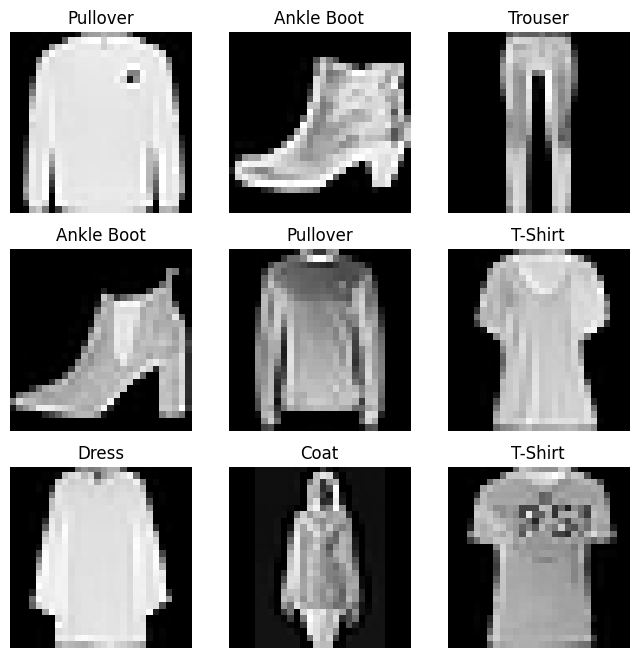

In [ ]:
# Visualize the Fashion Data, copied from https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(fashion_trainset), size=(1,)).item()
    img, label = fashion_trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
# fashion_trainset_np = np.array(fashion_trainset, dtype=object)
# fashion_testset_np = np.array(fashion_testset, dtype=object)

cifar_trainset_np = np.array(cifar_trainset, dtype=object)
cifar_testset_np = np.array(cifar_testset, dtype=object)

# Task 2

• Implement the MLP as a python class. The constructor for the class should take as input the activation function (e.g., ReLU), the number of hidden layers (e.g., 2) and the number of units in the hidden layers (e.g., [64, 64]) and it should initialize the weights and biases (with an initializer of your choice, except where otherwise specified) as well as other important properties of the MLP.

• The class should have (at least) two functions:
2

  – A fit function, which takes the training data (i.e., X and y)—as well as other hyperparameters (e.g., the learning rate and number of gradient descent iterations)—as input. This function should train your model by modifying the model parameters.

  – A predict function, which takes a set of input points (i.e., X) as input and outputs predictions (i.e., yˆ) for these points.

In [ ]:
def ReLU(x):
  return np.maximum(0, x)

def relu_back(x):
  return (x>0).astype(float)

def softmax(shifted_logits):
    # Shift the input values to prevent overflow
    # shifted_logits = X.dot(w)
    max_logits = np.max(shifted_logits, axis=1, keepdims=True)  # Compute the maximum value for each data point
    shifted_logits -= max_logits

    # Compute softmax
    exp_logits = np.exp(shifted_logits)
    softmax_output = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    return softmax_output
softmax_diff = lambda z: softmax(z)*(1-softmax(z))

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, 0.01 * x)
def leaky_relu_back(x):
    return np.where(x > 0, 1, 0.01)
tanh = lambda z: np.tanh(z)
def tanh_back(x):
  return 1.0 - np.tanh(x) ** 2


# logistic = lambda z: 1./ (1 + np.exp(-z))
# softmax = lambda z: np.exp(z-z.max()) / np.sum(np.exp(z-z.max()), axis = -1)[:, None]

In [ ]:
class MLP:

    #Implement the MLP as a python class. The constructor for the class should take as input the activation function (e.g., ReLU),
    #the number of hidden layers (e.g., 2) and the number of units in the hidden layers (e.g., [64, 64]) and it should initialize
    #the weights and biases (with an initializer of your choice, except where otherwise specified) as well as other important properties of the MLP.

    # def __init__(self, input_features, output_features, activation_function, hidden_layers=2, units_hlayers = 64, M = 64, biases = 0):
    def __init__(self, input_features, output_neurons, activation_function, activation_back, w_type, hidden_layers=2, units_hlayers = 64, M = 64, biases = 0, regularization=False, momentum=0.9):
        self.activation_function = activation_function
        self.activation_back = activation_back
        self.hidden_layers = hidden_layers
        self.units_hlayers = units_hlayers
        self.M = M
        self.input_features = input_features
        self.output_neurons = output_neurons
        self.w_type = w_type
        self.regularization = regularization
        # no. of weights dependent on hidden_layers
        self.weights = self.init_weights(self.hidden_layers)
        self.momentum =momentum


    def init_weights(self, hidden_layer = 2):
      if self.w_type == "z":
        if hidden_layer == 0:
          w = np.zeros((self.input_features, self.output_neurons))
          return np.asarray([w])
        if hidden_layer == 1:
          v = np.zeros((self.input_features, self.units_hlayers))
          f = np.zeros((self.units_hlayers, self.output_neurons))
          print("v: ", v.shape)
          print("f: ", f.shape)
          return np.asarray([v, f])


        if hidden_layer == 2:
          w = np.zeros((self.input_features, self.units_hlayers))
          v = np.zeros((self.units_hlayers, self.units_hlayers))
          f = np.zeros((self.units_hlayers, self.output_neurons))
          return np.asarray([w, v, f])

      elif self.w_type == "u":
        if hidden_layer == 0:
          w = np.random.uniform(-1, 1, size=(self.input_features, self.output_neurons))
          return np.asarray([w])
        if hidden_layer == 1:
          v = np.random.uniform(-1, 1, size=(self.input_features, self.units_hlayers))
          f = np.random.uniform(-1, 1, size=(self.units_hlayers, self.output_neurons))
          print("v: ", v.shape)
          print("f: ", f.shape)
          return np.asarray([v, f])

        if hidden_layer == 2:
          w = np.random.uniform(-1, 1, size=(self.input_features, self.units_hlayers))
          v = np.random.uniform(-1, 1, size=(self.units_hlayers, self.units_hlayers))
          f = np.random.uniform(-1, 1, size=(self.units_hlayers, self.output_neurons))
          return np.asarray([w, v, f])

      elif self.w_type == "g":
        if hidden_layer == 0:
          w = np.random.normal(0, 1, size=(self.input_features, self.output_neurons))
          return np.asarray([w])
        if hidden_layer == 1:
          v = np.random.normal(0, 1, size=(self.input_features, self.units_hlayers))
          f = np.random.normal(0, 1, size=(self.units_hlayers, self.output_neurons))
          print("v: ", v.shape)
          print("f: ", f.shape)
          return np.asarray([v, f])

        if hidden_layer == 2:
          w = np.random.normal(0, 1, size=(self.input_features, self.units_hlayers))
          v = np.random.normal(0, 1, size=(self.units_hlayers, self.units_hlayers))
          f = np.random.normal(0, 1, size=(self.units_hlayers, self.output_neurons))
          return np.asarray([w, v, f])

      elif self.w_type == "x":
        if hidden_layer == 0:
          w = np.random.uniform(-1, 1, size=(self.input_features, self.output_neurons)) * np.sqrt(6.0 / (self.input_features + self.output_neurons))
          return np.asarray([w])
        if hidden_layer == 1:
          v = np.random.uniform(-1, 1, size=(self.input_features, self.units_hlayers)) * np.sqrt(6.0 / (self.input_features + self.units_hlayers))
          f = np.random.uniform(-1, 1, size=(self.units_hlayers, self.output_neurons)) * np.sqrt(6.0 / (self.units_hlayers + self.output_neurons))
          print("v: ", v.shape)
          print("f: ", f.shape)
          return np.asarray([v, f])

        if hidden_layer == 2:
          w = np.random.uniform(-1, 1, size=(self.input_features, self.units_hlayers)) * np.sqrt(6.0 / (self.input_features + self.units_hlayers))
          v = np.random.uniform(-1, 1, size=(self.units_hlayers, self.units_hlayers)) * np.sqrt(6.0 / (self.units_hlayers + self.units_hlayers))
          f = np.random.uniform(-1, 1, size=(self.units_hlayers, self.output_neurons)) * np.sqrt(6.0 / (self.units_hlayers + self.output_neurons))
          return np.asarray([w, v, f])

      elif self.w_type == "k":
        if hidden_layer == 0:
          w = np.random.normal(0, np.sqrt(2.0 / self.input_features), size=(self.input_features, self.output_neurons))
          return np.asarray([w])
        if hidden_layer == 1:
          v = np.random.normal(0, np.sqrt(2.0 / self.input_features), size=(self.input_features, self.units_hlayers))
          f = np.random.normal(0, np.sqrt(2.0 / self.units_hlayers), size=(self.units_hlayers, self.output_neurons))
          print("v: ", v.shape)
          print("f: ", f.shape)
          return np.asarray([v, f])

        if hidden_layer == 2:
          w = np.random.normal(0, np.sqrt(2.0 / self.input_features), size=(self.input_features, self.units_hlayers))
          v = np.random.normal(0, np.sqrt(2.0 / self.units_hlayers), size=(self.units_hlayers, self.units_hlayers))
          f = np.random.normal(0, np.sqrt(2.0 / self.units_hlayers), size=(self.units_hlayers, self.output_neurons))
          return np.asarray([w, v, f])

      # if hidden_layer == 1:
      #   v = np.random.randn(self.input_features, self.units_hlayers)
      #   f = np.random.randn(self.units_hlayers, self.output_neurons)
      #   print("v: ", v.shape)
      #   print("f: ", f.shape)
      #   return np.asarray([v,f])

      # if hidden_layer == 2:
      #   w = np.random.randn(self.input_features, self.units_hlayers)
      #   v = np.random.randn(self.units_hlayers, self.units_hlayers)
      #   f = np.random.randn(self.units_hlayers, self.output_neurons)
      #   return np.asarray([w,v,f])

    def one_hot_encode(self, y):
        """
        Function which convert labels to vector

        :param labels: np.array of labels to convert
        :type labels: np.array
        :return: converted labels in one_hot_encode
        :rtype: np.array
        """
        num_classes = np.max(y)+1
        Y_hot = np.eye(num_classes)[y].astype(int)    # one_hot encoding of y
        # Y_hot = Y_hot[:, 1:]
        return Y_hot

    def one_hot_decode(self, labels) -> np.array:
        """
        Function which convert vector to labels

        :param labels: np.array of predicted labels to convert
        :type labels: np.array
        :return: converted labels from one_hot_encode
        :rtype: np.array
        """
        temp = np.transpose(labels)
        decode = [np.argmax(x) for x in temp]
        # if self.verbose:
        #     print(len(decode))
        return np.array(decode)

    def forward_pass(self, x):
      if self.hidden_layers == 0:
        self.f_params=[]

        f1 = np.dot(x, self.weights[0])
        f2 = softmax(f1)
        self.f_params = [x, f1]

        return f2

      if self.hidden_layers == 1:
        self.f_params = []

        f1 = np.dot(x, self.weights[0]) #60K X 64
        # print("f1: ",f1.shape)

        f2 = self.activation_function(f1) #60k x 64
        # print("f2: ",f2.shape)

        f3 = np.dot(f2, self.weights[1])
        fl = softmax(f3) #60k x 64

        # print("f1: ", f1.shape)
        # print("f2: ", f2.shape)
        # print("f3: ", f3.shape)
        # print("fl: ", fl.shape)

        self.f_params = [x,f1,f2,f3]

        return fl

      if self.hidden_layers == 2:
        self.f_params = []

        f1 = np.dot(x, self.weights[0]) #60K X 64
        # print("f1: ",f1.shape)

        f2 = self.activation_function(f1) #60k x 64
        # print("f2: ",f2.shape)

        f3 = np.dot(f2, self.weights[1])
        f4 = self.activation_function(f3) #60k x 64
        # print("f4: ",f4.shape)

        f5 = np.dot(f4, self.weights[2])
        fl = softmax(f5)

        self.f_params = [x,f1,f2,f3,f4,f5]

        return fl

    def backprop(self, y_train, yh):

      if self.hidden_layers == 0:
        x,f1 = self.f_params
        N = y_train.shape[0]
        dy = yh - y_train     # 60k x 10
        dw = np.dot(x.T, dy)/N
        return [dw]



      if self.hidden_layers == 1:
        x,f1,f2,f3 = self.f_params
        N = y_train.shape[0]
        dy = yh - y_train   # 60k x 10
        # dy = dy * softmax_diff(f3)
        df = np.dot(f2.T, dy)/N # 64 x 10

        # print("df: ", df.shape)

        # print(df)

        # d2 = relu_back(f1)  # 60K x 64
        # dx = np.dot((dz*d1), self.weights[1].T) # 60k x 64
        # dw = np.dot(x.T, (dx*d2)) #  784 x 60k

        dz = np.dot(dy, self.weights[1].T) #60k x 64
        d1 = self.activation_back(f1)    #60k x 64
        dv = np.dot(x.T, (dz*d1))/N  # 64 x 64

        # print("dv: ", dv.shape)
        # print(dw)

        return [dv, df]

      if self.hidden_layers == 2:
        x,f1,f2,f3,f4,f5 = self.f_params
        N = y_train.shape[0]
        dy = yh - y_train   # 60k x 10
        # dy = dy * softmax_diff(f5)
        df = np.dot(f4.T, dy)/N # 64 x 10

        # print(df)

        dz = np.dot(dy, self.weights[2].T) #60k x 64
        d1 = self.activation_back(f3)    #60k x 64
        dv = np.dot((dz*d1).T, f2)/N  # 64 x 64
        # print(dv)

        d2 = self.activation_back(f1)  # 60K x 64
        dx = np.dot((dz*d1), self.weights[1].T) # 60k x 64
        dw = np.dot(x.T, (dx*d2))/N #  784 x 60k
        # print(dw)

        return [dw, dv, df]

    def cost(self, x, y, ux):
      # nll = - np.mean(np.sum(ux*y, 1) - logsumexp(ux))
      N = x.shape[0]
      # priape)
      # nll = -np.mean(np.sum(ux * y, axis=1) - logsumexp(ux, axis=1))
      nll = - np.mean(np.sum(ux*y, 1) - logsumexp(ux))
      return nll

    def fit(self, x, y_tr, learning_rate=0.01, max_iters=100, epsilon=1e-8, lambda_l1=0.01, lambda_l2=0.01, batch_size=64, l1=False, l2=False):
      y = self.one_hot_encode(y_tr)
      costs = []  # List to store average costs for each epoch

      norms = np.array([np.inf])
      t = 1

      # Initialize velocities for momentum
      # velocities = [np.zeros_like(w) for w in self.weights]
      while t < max_iters and np.any(norms > epsilon):
        # Shuffle the data to create mini-batches
        permutation = np.random.permutation(x.shape[0])
        x_shuffled = x[permutation]
        y_shuffled = y[permutation]
        total_cost = 0  # Initialize the total cost for an epoch


        for batch_start in range(0, x.shape[0], batch_size):
            batch_end = min(batch_start + batch_size, x.shape[0])
            x_batch = x_shuffled[batch_start:batch_end]
            y_batch = y_shuffled[batch_start:batch_end]

            yh = self.forward_pass(x_batch)
            derivatives = self.backprop(y_batch, yh)

            # Calculate the cost for the mini-batch
            cost = self.cost(x_batch, y_batch, self.f_params[-1])

            # Add the cost to the total cost
            total_cost += cost
            for p in range(len(self.weights)):

              if self.regularization:
                # Regularization term gradients
                l1_grad = lambda_l1 * np.sign(self.weights[p])
                l2_grad = lambda_l2 * self.weights[p]
                if l1:
                  self.weights[p] -= learning_rate * (derivatives[p] + l1_grad)
                else:
                  self.weights[p] -= learning_rate * (derivatives[p] + l2_grad)



              else:
                # # Update the velocity with momentum
                # velocities[p] = self.momentum * velocities[p] - (learning_rate * derivatives[p])
                # # Update the weights with velocity
                # self.weights[p] -= velocities[p]
                self.weights[p] -= learning_rate * derivatives[p]
        average_cost = total_cost / (x.shape[0] // batch_size)
        costs.append(average_cost)  # Store the average cost for this epoch
        # print(f"Epoch {t}: Average Cost = {average_cost}")

        norms = np.array([np.linalg.norm(g) for g in derivatives])

        t += 1
        # cost = self.cost(x, y, self.f_params[-1])
        # print(cost)
        # print(self.weights)

      return costs

    def predict(self, x):
      # y = self.one_hot_decode()
      yh = self.forward_pass(x)
      return np.argmax(yh, axis=-1)

    def accuracy(self, x, y):
      y_pred=self.forward_pass(x)
      # Calculate the predicted class (index with the highest probability) for each data point
      predicted_class = np.argmax(y_pred, axis=1)

      # Calculate the true class (index with value 1 in one-hot encoding) for each data point
      true_class = np.argmax(y, axis=1)

      # Compare the predicted class with the true class to determine correct predictions
      correct_predictions = np.sum(predicted_class == true_class)
      total_predictions = len(y)
      accuracy = correct_predictions / total_predictions

      return accuracy

## Task 3


1. First of all, experiment with initializing your model weights in a few different ways. Create several MLPs with a single hidden
 layer having 128 units, initializing the weights as (1) all zeros (2) Uniform [-1, 1] (3) Gaussian N(0,1) (4) Xavier (5) Kaiming. After training these models, compare the effect of weight initialization on the training curves and test accuracy on the Fashion MNIST dataset.



In [ ]:
mdl = MLP(784, 10, ReLU, relu_back, w_type="z", hidden_layers=1, units_hlayers=128)
# print(y2.shape)
ce = mdl.fit(X_train, y_train)
y2 = mdl.one_hot_encode(y_test)

y_pred=mdl.predict(X_train)
# print(y2.shape)
# print(y_pred.shape)
tr_acc = mdl.accuracy(X_test, y2)
# print(y_pred)
print(tr_acc)
y3 = mdl.one_hot_encode(y_test)
acc = mdl.accuracy(X_test, y3)
print(acc)

<ipython-input-8-b646c230b106>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([w, v, f])


0.1


In [ ]:
mdl = MLP(784, 10, ReLU, relu_back, w_type="u", hidden_layers=1, units_hlayers=128)
# print(y2.shape)
ce = mdl.fit(X_train, y_train)
y2 = mdl.one_hot_encode(y_train)

y_pred=mdl.predict(X_train)
# print(y2.shape)
# print(y_pred.shape)
tr_acc = mdl.accuracy(X_train, y2)
# print(y_pred)
print(tr_acc)
y3 = mdl.one_hot_encode(y_test)
acc = mdl.accuracy(X_test, y3)
print(acc)


v:  (784, 128)
f:  (128, 10)


<ipython-input-26-f9688c7ea585>:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([v, f])


KeyboardInterrupt: ignored

In [ ]:
mdl = MLP(784, 10, ReLU, relu_back, w_type="g", hidden_layers=1, units_hlayers=128)
# print(y2.shape)
ce = mdl.fit(X_train, y_train)
y2 = mdl.one_hot_encode(y_train)

y_pred=mdl.predict(X_train)
# print(y2.shape)
# print(y_pred.shape)
tr_acc = mdl.accuracy(X_train, y2)
# print(y_pred)
print(tr_acc)
y3 = mdl.one_hot_encode(y_test)
acc = mdl.accuracy(X_test, y3)
print(acc)

In [ ]:
mdl = MLP(784, 10, ReLU, relu_back, w_type="x", hidden_layers=1, units_hlayers=128)
# print(y2.shape)
ce = mdl.fit(X_train, y_train)
y2 = mdl.one_hot_encode(y_train)

y_pred=mdl.predict(X_train)
# print(y2.shape)
# print(y_pred.shape)
tr_acc = mdl.accuracy(X_train, y2)
# print(y_pred)
print(tr_acc)
y3 = mdl.one_hot_encode(y_test)
acc = mdl.accuracy(X_test, y3)
print(acc)

<ipython-input-8-b646c230b106>:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([w, v, f])


0.97775


In [ ]:
mdl = MLP(784, 10, ReLU, relu_back, w_type="k", hidden_layers=1, units_hlayers=128)
# print(y2.shape)
ce = mdl.fit(X_train, y_train)
y2 = mdl.one_hot_encode(y_train)

y_pred=mdl.predict(X_train)
# print(y2.shape)
# print(y_pred.shape)
tr_acc = mdl.accuracy(X_train, y2)
# print(y_pred)
print(tr_acc)
y3 = mdl.one_hot_encode(y_test)
acc = mdl.accuracy(X_test, y3)
print(acc)


<ipython-input-8-b646c230b106>:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([w, v, f])


0.9882166666666666


In [ ]:

learning_rates = [0.02, 0.01, 0.03]  # Define the learning rates to experiment with
training_curves = {}  # Dictionary to store training curves for each learning rate

for learning_rate in learning_rates:
    mdl = MLP(784, 10, ReLU, relu_back, w_type="k", hidden_layers=2)
    costs = mdl.fit(X_train, y_train, learning_rate=learning_rate)  # Train the model

    # Store the training curves (costs) for this learning rate
    training_curves[f"Learning Rate {learning_rate}"] = costs

# Plot the training curves for each learning rate
plt.figure(figsize=(10, 6))
for label, costs in training_curves.items():
    plt.plot(range(len(costs)), costs, label=label)

plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Curves for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.savefig('2.jpg')


<ipython-input-7-6c3f9629bcc3>:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([w, v, f])


v:  (784, 128)
f:  (128, 10)
v:  (784, 128)
f:  (128, 10)
v:  (784, 128)
f:  (128, 10)
v:  (784, 128)
f:  (128, 10)
v:  (784, 128)
f:  (128, 10)
Training model with weight initialization: z


<ipython-input-26-f9688c7ea585>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([v, f])
<ipython-input-26-f9688c7ea585>:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([v, f])
<ipython-input-26-f9688c7ea585>:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([v, f])
<ipython-i

Training model with weight initialization: u
Training model with weight initialization: g
Training model with weight initialization: x
Training model with weight initialization: k


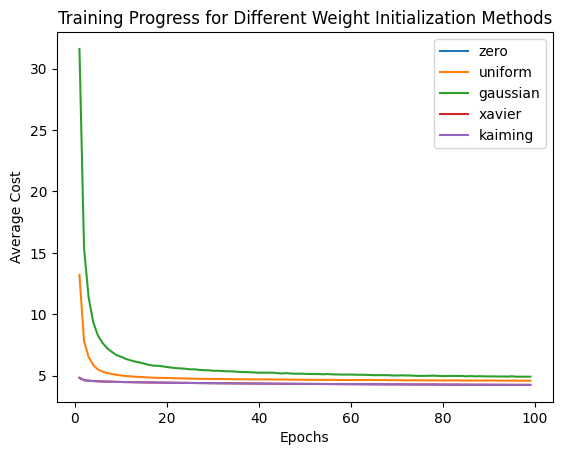

In [ ]:

# Create MLP instances with different weight initializations
weight_initializations = ['zero', 'uniform', 'gaussian', 'xavier', 'kaiming']
models = []

for w_type in weight_initializations:
    model = MLP(784, 10, ReLU, relu_back, w_type=w_type[0], hidden_layers=1, units_hlayers=128)
    models.append(model)

# Train and evaluate each model
all_costs = []

for model in models:
    print(f"Training model with weight initialization: {model.w_type}")
    costs = model.fit(X_train, y_train)
    all_costs.append(costs)



# Plot the training progress for all weight initialization methods
plt.figure()
for i, init_method in enumerate(weight_initializations):
    plt.plot(range(1, len(all_costs[i]) + 1), all_costs[i], label=init_method)

plt.xlabel('Epochs')
plt.ylabel('Average Cost')
plt.title('Training Progress for Different Weight Initialization Methods')
plt.legend()
plt.show()


In [ ]:
plt.savefig('1.jpg')

<Figure size 640x480 with 0 Axes>

2. Create three different models: (1) an MLP with no hidden layers, i.e., it directly maps the inputs to outputs, (2) an MLP with a single hidden layer having 128 units and ReLU activations, (3) an MLP with 2 hidden layers each having 128 units with ReLU activations. It should be noted that since we want to perform classification, all of these models should have a softmax layer at the end. After training, compare the test accuracy of these three models on the Fashion MNIST dataset. Comment on how non-linearity and network depth affects the accuracy. Are the results that you obtain expected?



In [ ]:
#(1) an MLP with no hidden layers
mdl = MLP(784, 10, ReLU, relu_back, w_type="k", hidden_layers=0)
# print(y2.shape)
ce = mdl.fit(X_train, y_train)
y2 = mdl.one_hot_encode(y_train)

y_pred=mdl.predict(X_train)
# print(y2.shape)
# print(y_pred.shape)
tr_acc = mdl.accuracy(X_train, y2)
# print(y_pred)
print(tr_acc)
y3 = mdl.one_hot_encode(y_test)
acc = mdl.accuracy(X_test, y3)
print(acc)

0.8770166666666667
0.8423


In [ ]:
#2) an MLP with a single hidden layer having 128 units and ReLU activations
mdl = MLP(784, 10, ReLU, relu_back, w_type="k", hidden_layers=1, units_hlayers=128)
# print(y2.shape)
ce = mdl.fit(X_train, y_train)
y2 = mdl.one_hot_encode(y_train)

y_pred=mdl.predict(X_train)
# print(y2.shape)
# print(y_pred.shape)
tr_acc = mdl.accuracy(X_train, y2)
# print(y_pred)
print(tr_acc)
y3 = mdl.one_hot_encode(y_test)
acc = mdl.accuracy(X_test, y3)
print(acc)

v:  (784, 128)
f:  (128, 10)


<ipython-input-36-c6f98a091e40>:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([v, f])


0.9807
0.888


In [ ]:
#(3) an MLP with 2 hidden layers each having 128 units with ReLU activations.
mdl = MLP(784, 10, ReLU, relu_back, w_type="k", hidden_layers=2, units_hlayers=128)
# print(y2.shape)
ce = mdl.fit(X_train, y_train)
y2 = mdl.one_hot_encode(y_train)

y_pred=mdl.predict(X_train)
# print(y2.shape)
# print(y_pred.shape)
tr_acc = mdl.accuracy(X_train, y2)
# print(y_pred)
print(tr_acc)
y3 = mdl.one_hot_encode(y_test)
acc = mdl.accuracy(X_test, y3)
print(acc)


<ipython-input-8-b646c230b106>:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([w, v, f])


0.9862166666666666
0.8734


3. Take the last model above, the one with 2 hidden layers, and create two different copies of it in which you pick two activations of your choice (except ReLU) from the course slides. After training these two models on Fashion MNIST compare their test accuracies with the model with ReLU activations. Comment on the performances of these models: which one is better and why? Are certain activations better than others? If the results are not as you expected, what could be the reason?

In [ ]:
#tanh
mdl = MLP(784, 10, tanh, tanh_back, w_type="k", hidden_layers=2, units_hlayers=128)
# print(y2.shape)
ce = mdl.fit(X_train, y_train)
y2 = mdl.one_hot_encode(y_train)

y_pred=mdl.predict(X_train)
# print(y2.shape)
# print(y_pred.shape)
tr_acc = mdl.accuracy(X_train, y2)
# print(y_pred)
print(tr_acc)
y3 = mdl.one_hot_encode(y_test)
acc = mdl.accuracy(X_test, y3)
print(acc)



<ipython-input-36-c6f98a091e40>:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([w, v, f])


0.9828166666666667
0.872


In [ ]:
#leaky relu
mdl = MLP(784, 10, leaky_relu, leaky_relu_back, w_type="k", hidden_layers=2, units_hlayers=128)
# print(y2.shape)
ce = mdl.fit(X_train, y_train)
y2 = mdl.one_hot_encode(y_train)

y_pred=mdl.predict(X_train)
# print(y2.shape)
# print(y_pred.shape)
tr_acc = mdl.accuracy(X_train, y2)
# print(y_pred)
print(tr_acc)
y3 = mdl.one_hot_encode(y_test)
acc = mdl.accuracy(X_test, y3)
print(acc)

<ipython-input-36-c6f98a091e40>:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([w, v, f])


4. Create an MLP with 2 hidden layers each having 128 units with ReLU activations as above. However, this time, independently add L1 and L2 regularization to the network and train the MLP in this way. How do these
regularizations affect the accuracy? (This proportion can be varied as a tunable hyperparameter that can be explored as part of other project requirements)

In [ ]:
#(3) an MLP with 2 hidden layers each having 128 units with ReLU activations.
mdl = MLP(784, 10, ReLU, relu_back, w_type="k", hidden_layers=2, units_hlayers=128, regularization = True)
# print(y2.shape)
ce = mdl.fit(X_train, y_train, l2=True)
y2 = mdl.one_hot_encode(y_train)

y_pred=mdl.predict(X_train)
# print(y2.shape)
# print(y_pred.shape)
tr_acc = mdl.accuracy(X_train, y2)
# print(y_pred)
print(tr_acc)
y3 = mdl.one_hot_encode(y_test)
acc = mdl.accuracy(X_test, y3)
print(acc)

#(3) an MLP with 2 hidden layers each having 128 units with ReLU activations.
mdl = MLP(784, 10, ReLU, relu_back, w_type="k", hidden_layers=2, units_hlayers=128, regularization = True)
# print(y2.shape)
ce = mdl.fit(X_train, y_train, l1=True)
y2 = mdl.one_hot_encode(y_train)

y_pred=mdl.predict(X_train)
# print(y2.shape)
# print(y_pred.shape)
tr_acc = mdl.accuracy(X_train, y2)
# print(y_pred)
print(tr_acc)
y3 = mdl.one_hot_encode(y_test)
acc = mdl.accuracy(X_test, y3)
print(acc)



<ipython-input-38-6c3f9629bcc3>:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([w, v, f])


0.8973333333333333
0.869
0.6631833333333333
0.6533



5. Create an MLP with 2 hidden layers each having 128 units with ReLU activations as above. However, this time, train it with unnormalized images. How does this affect the accuracy?

In [ ]:
#(3) an MLP with 2 hidden layers each having 128 units with ReLU activations.
mdl = MLP(784, 10, ReLU, relu_back, w_type="k", hidden_layers=2, units_hlayers=128)
# print(y2.shape)
ce = mdl.fit(X_train_unnorm, y_train)
y2 = mdl.one_hot_encode(y_train)

y_pred=mdl.predict(X_train)
# print(y2.shape)
# print(y_pred.shape)
tr_acc = mdl.accuracy(X_train_unnorm, y2)
# print(y_pred)
print(tr_acc)
y3 = mdl.one_hot_encode(y_test)
acc = mdl.accuracy(X_test_unnorm, y3)
print(acc)


<ipython-input-26-f9688c7ea585>:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([w, v, f])


0.10006666666666666
0.1001


6. Using PyTorch, create a convolutional neural network (CNN) with 2 convolutional and 2 fully connected layers.
Although you are free in your choice of the hyperparameters of the convolutional layers,
set the number of units in the fully connected layers to be 128. Also, set the activations in all of the layers to be ReLU.
Train this CNN on the Fashion MNIST dataset. Does using a CNN increase/decrease the accuracy compared to using MLPs? Provide comments on your results.


In [ ]:
# 6. Mostly inspired from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim

class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [ ]:
net = FashionCNN()

batch_size = 64
learning_rate = 0.001
num_epochs = 2

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model = FashionCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

# Training loop
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
        if i % 937 == 936:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 937:.3f}')
            running_loss = 0.0

print('Finished Training')
torch.save(net.state_dict(), 'fashion_mnist_cnn_model.pth')

In [ ]:
# dataiter = iter(trainloader)
# images, labels = next(dataiter)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

dataiter = iter(testloader)
images, labels = next(dataiter)

net = FashionCNN()
net.load_state_dict(torch.load("/content/fashion_mnist_cnn_model.pth"))
outputs = net(images)

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 75 %


7. Now using the CIFAR-10 dataset, train an MLP using your implementation (with whatever layer dimensions you like), and a CNN with the same architecture restrictions as in (6). How does using a CNN increase/decrease the accuracy compared to using MLPs on this dataset?

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:04<00:00, 40876662.73it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torch.nn as nn
import torch.nn.functional as F

class CifarCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = CifarCNN()




In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
net = CifarCNN()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %


8. In your CNN implemented with PyTorch, investigate the effects of optimizer on performance on the CIFAR- 10 dataset. Using an SGD optimizer, set the momentum factor to zero, and then try to increase it. How does changing this value impact the training and performance of the network in terms of convergence speed, final accuracy, and stability? How do these compare if you instead use an Adam optimizer?

In [ ]:
net = CifarCNN()

import torch.optim as optim
import time

criterion = nn.CrossEntropyLoss()

for j in [0,0.1,0.5,0.7,0.9]:
  net = CifarCNN()

  numStr = str(j)

  # print(PATH)
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=j)
  # optimizer = optim.Adam(model.parameters(), lr=0.001, momentum=i)
  start = time.time()

  for epoch in range(2):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % 2000 == 1999:    # print every 2000 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
              running_loss = 0.0
  end = time.time()

  print('Finished Training for momentum in SGD ' + numStr)
  print('Time taken: ', end-start)
  PATH = './cifar_net'+numStr+'.pth'
  torch.save(net.state_dict(), PATH)



[1,  2000] loss: 2.301
[1,  4000] loss: 2.296
[1,  6000] loss: 2.281
[1,  8000] loss: 2.238
[1, 10000] loss: 2.188
[1, 12000] loss: 2.127
[2,  2000] loss: 2.041
[2,  4000] loss: 1.977
[2,  6000] loss: 1.950
[2,  8000] loss: 1.887
[2, 10000] loss: 1.840
[2, 12000] loss: 1.772
Finished Training for momentum in SGD 0
Time taken:  131.85588932037354
[1,  2000] loss: 2.303
[1,  4000] loss: 2.302
[1,  6000] loss: 2.301
[1,  8000] loss: 2.298
[1, 10000] loss: 2.291
[1, 12000] loss: 2.265
[2,  2000] loss: 2.135
[2,  4000] loss: 2.035
[2,  6000] loss: 1.964
[2,  8000] loss: 1.924
[2, 10000] loss: 1.857
[2, 12000] loss: 1.818
Finished Training for momentum in SGD 0.1
Time taken:  135.7267723083496
[1,  2000] loss: 2.302
[1,  4000] loss: 2.294
[1,  6000] loss: 2.206
[1,  8000] loss: 2.024
[1, 10000] loss: 1.932
[1, 12000] loss: 1.856
[2,  2000] loss: 1.726
[2,  4000] loss: 1.654
[2,  6000] loss: 1.610
[2,  8000] loss: 1.568
[2, 10000] loss: 1.545
[2, 12000] loss: 1.525
Finished Training for momen

In [ ]:
import torch.optim as optim
import time

criterion = nn.CrossEntropyLoss()

# for i in [0,0.1,0.5,0.7,0.9]:
net = CifarCNN()

# print(PATH)
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=i)
optimizer = optim.Adam(net.parameters(), lr=0.001)
start = time.time()

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
end = time.time()

print('Finished Training for momentum in SGD ' + numStr)
print('Time taken: ', end-start)
PATH = './cifar_net_adam.pth'
torch.save(net.state_dict(), PATH)

[1,  2000] loss: 1.855
[1,  4000] loss: 1.607
[1,  6000] loss: 1.528
[1,  8000] loss: 1.465
[1, 10000] loss: 1.449
[1, 12000] loss: 1.407
[2,  2000] loss: 1.343
[2,  4000] loss: 1.292
[2,  6000] loss: 1.310
[2,  8000] loss: 1.279
[2, 10000] loss: 1.288
[2, 12000] loss: 1.287
Finished Training for momentum in SGD 0.9
Time taken:  182.84347891807556


In [ ]:
correct = 0
total = 0
net.load_state_dict(torch.load("/content/cifar_net"+str(j)+".pth"))
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %


Momentum = 0
Accuracy of the network on the 10000 test images: 38 %
Momentum = 0.1
Accuracy of the network on the 10000 test images: 35 %
Momentum = 0.5
Accuracy of the network on the 10000 test images: 47 %
Momentum = 0.7
Accuracy of the network on the 10000 test images: 48 %
Momentum = 0.9
Accuracy of the network on the 10000 test images: 54 %


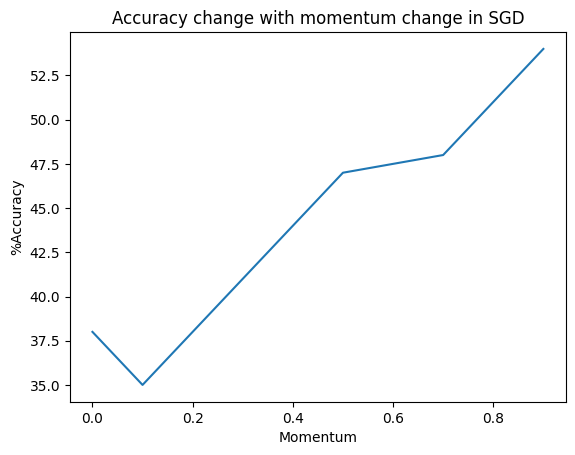

In [ ]:

# since we're not training, we don't need to calculate the gradients for our outputs
accuracies = []

for j in [0,0.1,0.5,0.7,0.9]:
  correct = 0
  total = 0
  net = CifarCNN()
  net.load_state_dict(torch.load("/content/cifar_net"+str(j)+".pth"))
  with torch.no_grad():

      for data in testloader:
          images, labels = data
          # calculate outputs by running images through the network
          outputs = net(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print("Momentum = " + str(j))
  print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
  accuracies.append(100 * correct // total)



# for i in :
#   print(i,"% training data")
#   mse, r2 = testing(1 - i/100)
#   print("MSE: ", mse)
#   print('\n')

#   Percentages.append(i)
#   MSEBoston.append(mse)
#   r2s.append(r2)

#   i *= 8

# print(MSEBoston)
plt.plot([0,0.1,0.5,0.7,0.9], accuracies)
plt.title('Accuracy change with momentum change in SGD')
plt.xlabel('Momentum')
plt.ylabel('%Accuracy')
plt.show()
# plt.savefig('growing_subsets_boston.png')

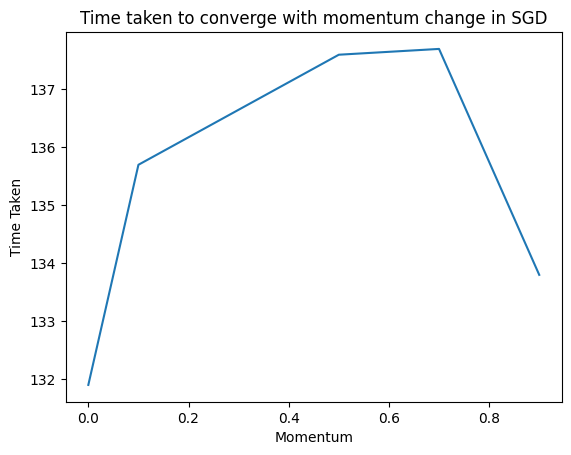

In [ ]:
time_taken = [131.9,135.7,137.6,137.7,133.8]
plt.plot([0,0.1,0.5,0.7,0.9], time_taken)
plt.title('Time taken to converge with momentum change in SGD')
plt.xlabel('Momentum')
plt.ylabel('Time Taken')
plt.show()